# Applied Bioinformatics Lecture 6
## Functional Gene Set and Pathway Analyses
### By Chunlei Wu

This is the sample code for the Applied Bioinformatics lecture #6, Functional Gene Set and Pathway Analyses, at TSRI.

## Outlines:
 * Hypogeometric distribution and Fisher Exact Test
 * Mapping gene IDs to pathway and GO annotations
 * SPIA analysis for KEGG pathways
 * Homework


### Hypogeometric distribution and Fisher Exact Test

Suppose an experiment produced data points for 5193 genes, 13 genes were selected as the significant gene list after the analysis (the table below). Out of these 13 genes, 3 genes, *IL10RA, IL22, IL23A*, were found from **Jak-STAT signaling pathway**:

|Gene	|Pathway|
|-------|-----------|
|ACP6	|Riboflavin metabolism|
|ALDH1B1	|Limonene and pinene degradation|
|ARFGAP1	|Endocytosis|
|COX6C	|Oxidative phosphorylation|
|CYP21A2	|C21-Steroid hormone metabolism|
|GAB2	|Fc gamma R-mediated phagocytosis|
|IBSP	|ECM-receptor interaction|
|IL10RA	|Jak-STAT signaling pathway|
|IL22	|Jak-STAT signaling pathway|
|IL23A	|Jak-STAT signaling pathway|
|NFKB1	|Cytosolic DNA-sensing pathway|
|TCEB2	|Renal cell carcinoma|
|VARS2	|Valine, leucine and isoleucine biosynthesis|

Now, we would like to find out if **Jak-STAT signaling pathway** is significantly over-represented in this top 13 gene-list. This can be done via *Fisher Exact Test*.

First, we need to form a 2x2 contegency table as the below:

In [3]:
data = matrix(c(3, 152, 10, 5028), nrow=2)
data

3,10
152,5028


Then, performing fisher exact test is very straightforward in R:

In [4]:
fisher.test(data, alternative='greater')


	Fisher's Exact Test for Count Data

data:  data
p-value = 0.005985
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 2.314823      Inf
sample estimates:
odds ratio 
  9.908603 


Note that we use `alternative='greater'` to test for over-representation.

This is equivelant to compute the summation of the probabilities of hypergeomatric distribution for picking 3 genes or more out of 13 gene-list by chance.

In [5]:
data.frame(a=3:13, p.value=dhyper(3:13, 3+152, 10+5028, 3+10))

,a,p.value
1,3,0.005542429
2,4,0.0004187956
3,5,2.262995e-05
4,6,8.996203e-07
5,7,2.66382e-08
6,8,5.874906e-10
7,9,9.53087e-12
8,10,1.105467e-13
9,11,8.680741e-16
10,12,4.136148e-18


In [6]:
sum(dhyper(3:13, 3+152, 10+5028, 3+10))

[1] 0.005984782

### Mapping gene IDs to pathway and GO annotations

Often time, you get a list of candidate genes back from your experiment, now you need to map these genes to functional annotations, like pathways or Gene Ontologies (GO), so that you can generate some hypothesis to test, or perform further analysis to narrow down the list.

Here, we use a bioconductor package, **mygene**, for this task. See its [bioconductor page](http://bioconductor.org/packages/release/bioc/html/mygene.html) for installation instruction. **mygene** utilizes [MyGene.info](http://mygene.info) web services to provide always up-to-date gene annotations, without the need of updating your local R packages. **mygene** package can provide many gene-specific annotations, but here we will demo how to use it to map gene ids to pathway and GO annotations.

In [7]:
library(mygene)

Loading required package: GenomicFeatures
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRange

Here are two test gene lists, in NCBI gene IDs and Ensembl gene IDs, respectively:

In [8]:
gene.list1 = c(3491, 2353, 1958, 1843, 3725, 23645, 9510, 84869, 7432, 1490)

In [9]:
gene.list2 = c("ENSG00000118523", "ENSG00000120129", "ENSG00000120738", "ENSG00000170345", "ENSG00000087074", 
               "ENSG00000142871", "ENSG00000177606", "ENSG00000146469", "ENSG00000145439", "ENSG00000154734")

Let's provide two convenient functions for mapping the input gene id list to pathways and GO annotations:

In [10]:
map2pathway = function(id.list, scopes='entrezgene', pathway.src="kegg", sep=', '){
  pw.field = paste('pathway', pathway.src, sep=".")
  res = queryMany(id.list, scopes=scopes, fields=pw.field)
  format.pathway = function(one.res){
    id = one.res$query
    if (!is.null(one.res[[pw.field]])){
      pw.names = paste(one.res[[pw.field]]$name, collapse=sep)
      pw.ids = paste(one.res[[pw.field]]$id, collapse=sep)
      return(c(id, pw.ids, pw.names))
    }else{
      return(c(id, NA, NA))
    }
  }
 out = apply(as.data.frame(res), 1, format.pathway)
 out = t(out)
 colnames(out) <- c('id', paste(pathway.src, '.id', sep=''), paste(pathway.src, '.name', sep=''))
 return(out)
}


In [11]:
map2go = function(id.list, scopes='entrezgene', go.branch='BP', sep=', ', species='human'){
  go.branch = toupper(go.branch)
  go.field = paste('go', go.branch, sep=".")
  res = queryMany(id.list, scopes=scopes, fields=go.field, species=species)
  format.go = function(one.res){
    id = one.res$query
    if (!is.null(one.res[[go.field]])){
      go.terms = paste(one.res[[go.field]]$term, collapse=sep)
      go.ids = paste(one.res[[go.field]]$id, collapse=sep)
      return(c(id, go.ids, go.terms))
    }else{
      return(c(id, NA, NA))
    }
  }
  out = apply(as.data.frame(res), 1, format.go)
  out = t(out)
  colnames(out) <- c('id', 'go.id', 'go.term')
  return(out)
}


Now, we can call these functions to map gene IDs to various pathway resources and GO:

In [12]:
map2pathway(gene.list1, sep='<br>')

Finished


,id,kegg.id,kegg.name
1,3491,NA,NA
2,2353,hsa04010hsa04024hsa04380hsa04620hsa04660hsa04662hsa04668hsa04713hsa04725hsa04728hsa04915hsa04917hsa04921hsa05031hsa05132hsa05133hsa05140hsa05142hsa05161hsa05166hsa05168hsa05200hsa05210hsa05231hsa05323,MAPK signaling pathway - Homo sapiens (human)cAMP signaling pathway - Homo sapiens (human)Osteoclast differentiation - Homo sapiens (human)Toll-like receptor signaling pathway - Homo sapiens (human)T cell receptor signaling pathway - Homo sapiens (human)B cell receptor signaling pathway - Homo sapiens (human)TNF signaling pathway - Homo sapiens (human)Circadian entrainment - Homo sapiens (human)Cholinergic synapse - Homo sapiens (human)Dopaminergic synapse - Homo sapiens (human)Estrogen signaling pathway - Homo sapiens (human)Prolactin signaling pathway - Homo sapiens (human)Oxytocin signaling pathway - Homo sapiens (human)Amphetamine addiction - Homo sapiens (human)Salmonella infection - Homo sapiens (human)Pertussis - Homo sapiens (human)Leishmaniasis - Homo sapiens (human)Chagas disease (American trypanosomiasis) - Homo sapiens (human)Hepatitis B - Homo sapiens (human)HTLV-I infection - Homo sapiens (human)Herpes simplex infection - Homo sapiens (human)Pathways in cancer - Homo sapiens (human)Colorectal cancer - Homo sapiens (human)Choline metabolism in cancer - Homo sapiens (human)Rheumatoid arthritis - Homo sapiens (human)
3,1958,hsa05020hsa05166,Prion diseases - Homo sapiens (human)HTLV-I infection - Homo sapiens (human)
4,1843,hsa04010hsa04726,MAPK signaling pathway - Homo sapiens (human)Serotonergic synapse - Homo sapiens (human)
5,3725,hsa04010hsa04012hsa04024hsa04310hsa04380hsa04510hsa04620hsa04660hsa04662hsa04668hsa04722hsa04912hsa04915hsa04921hsa04932hsa05030hsa05031hsa05120hsa05132hsa05133hsa05140hsa05142hsa05161hsa05164hsa05166hsa05168hsa05169hsa05200hsa05203hsa05210hsa05211hsa05231hsa05321hsa05323,MAPK signaling pathway - Homo sapiens (human)ErbB signaling pathway - Homo sapiens (human)cAMP signaling pathway - Homo sapiens (human)Wnt signaling pathway - Homo sapiens (human)Osteoclast differentiation - Homo sapiens (human)Focal adhesion - Homo sapiens (human)Toll-like receptor signaling pathway - Homo sapiens (human)T cell receptor signaling pathway - Homo sapiens (human)B cell receptor signaling pathway - Homo sapiens (human)TNF signaling pathway - Homo sapiens (human)Neurotrophin signaling pathway - Homo sapiens (human)GnRH signaling pathway - Homo sapiens (human)Estrogen signaling pathway - Homo sapiens (human)Oxytocin signaling pathway - Homo sapiens (human)Non-alcoholic fatty liver disease (NAFLD) - Homo sapiens (human)Cocaine addiction - Homo sapiens (human)Amphetamine addiction - Homo sapiens (human)Epithelial cell signaling in Helicobacter pylori infection - Homo sapiens (human)Salmonella infection - Homo sapiens (human)Pertussis - Homo sapiens (human)Leishmaniasis - Homo sapiens (human)Chagas disease (American trypanosomiasis) - Homo sapiens (human)Hepatitis B - Homo sapiens (human)Influenza A - Homo sapiens (human)HTLV-I infection - Homo sapiens (human)Herpes simplex infection - Homo sapiens (human)Epstein-Barr virus infection - Homo sapiens (human)Pathways in cancer - Homo sapiens (human)Viral carcinogenesis - Homo sapiens (human)Colorectal cancer - Homo sapiens (human)Renal cell carcinoma - Homo sapiens (human)Choline metabolism in cancer - Homo sapiens (human)Inflammatory bowel disease (IBD) - Homo sapiens (human)Rheumatoid arthritis - Homo sapiens (human)
6,23645,hsa04141,Protein processing in endoplasmic reticulum - Homo sapiens (human)
7,9510,NA,NA
8,84869,NA,NA
9,7432,NA,NA
10,1490,hsa04390,Hippo signaling pathway - Homo sapiens (human)


In [13]:
map2pathway(gene.list1, pathway.src='biocarta', sep='<br>')

Finished


,id,biocarta.id,biocarta.name
1,3491,NA,NA
2,2353,arenrf2pathwayat1rpathwaybcrpathwaycardiacegfpathwayccr5pathwaycdmacpathwaydreampathwayetspathwayfcer1pathwaygleevecpathwayhbxpathwayigf1pathwayil1rpathwayil2rbpathwayil3pathwaykeratinocytepathwaymapkpathwayngfpathwaypdgfpathwayranklpathwaytcrpathwaytollpathwaytpopathwaytsp1pathway,oxidative stress induced gene expression via nrf2angiotensin ii mediated activation of jnk pathway via pyk2 dependent signalingbcr signaling pathwayrole of egf receptor transactivation by gpcrs in cardiac hypertrophypertussis toxin-insensitive ccr5 signaling in macrophagecadmium induces dna synthesis and proliferation in macrophagesrepression of pain sensation by the transcriptional regulator dreammets affect on macrophage differentiationfc epsilon receptor i signaling in mast cellsinhibition of cellular proliferation by gleeveccalcium signaling by hbx of hepatitis b virusigf-1 signaling pathwaysignal transduction through il1ril-2 receptor beta chain in t cell activationil 3 signaling pathwaykeratinocyte differentiationmapkinase signaling pathwaynerve growth factor pathway (ngf)pdgf signaling pathwaybone remodelingt cell receptor signaling pathwaytoll-like receptor pathwaytpo signaling pathwaytsp-1 induced apoptosis in microvascular endothelial cell
3,1958,cdk5pathway,phosphorylation of mek1 by cdk5/p35 down regulates the map kinase pathway
4,1843,dsppathwaynthipathwaypparapathway,regulation of map kinase pathways through dual specificity phosphatasesnfkb activation by nontypeable hemophilus influenzaemechanism of gene regulation by peroxisome proliferators via ppara
5,3725,41bbpathwayagrpathwayarenrf2pathwayat1rpathwayatmpathwaybcrpathwaycardiacegfpathwayccr5pathwaycdmacpathwayd4gdipathwaydreampathwayeponfkbpathwayetspathwayfcer1pathwaygleevecpathwayhbxpathwayhifpathwayigf1pathwayil12pathwayil1rpathwaykeratinocytepathwaymapkpathwayngfpathwaypcafpathwaypdgfpathwaypparapathwaypyk2pathwaystresspathwaytcrpathwaytollpathwaytpopathwaytsp1pathway,the 41bb-dependent immune responseagrin in postsynaptic differentiationoxidative stress induced gene expression via nrf2angiotensin ii mediated activation of jnk pathway via pyk2 dependent signalingatm signaling pathwaybcr signaling pathwayrole of egf receptor transactivation by gpcrs in cardiac hypertrophypertussis toxin-insensitive ccr5 signaling in macrophagecadmium induces dna synthesis and proliferation in macrophagesd4gdi signaling pathwayrepression of pain sensation by the transcriptional regulator dreamerythropoietin mediated neuroprotection through nf-kbmets affect on macrophage differentiationfc epsilon receptor i signaling in mast cellsinhibition of cellular proliferation by gleeveccalcium signaling by hbx of hepatitis b virushypoxia-inducible factor in the cardivascular systemigf-1 signaling pathwayil12 and stat4 dependent signaling pathway in th1 developmentsignal transduction through il1rkeratinocyte differentiationmapkinase signaling pathwaynerve growth factor pathway (ngf)the information processing pathway at the ifn beta enhancerpdgf signaling pathwaymechanism of gene regulation by peroxisome proliferators via pparalinks between pyk2 and map kinasestnf/stress related signalingt cell receptor signaling pathwaytoll-like receptor pathwaytpo signaling pathwaytsp-1 induced apoptosis in microvascular endothelial cell
6,23645,NA,NA
7,9510,NA,NA
8,84869,NA,NA
9,7432,NA,NA
10,1490,NA,NA


In [14]:
map2pathway(gene.list2, scopes='ensembl.gene', pathway.src='reactome', sep='<br>')

Finished


,id,reactome.id,reactome.name
1,ENSG00000118523,NA,NA
2,ENSG00000120129,R-HSA-112399R-HSA-112409R-HSA-112412R-HSA-1227986R-HSA-1236394R-HSA-1250196R-HSA-1250347R-HSA-1266738R-HSA-1280215R-HSA-1433557R-HSA-162582R-HSA-166520R-HSA-167044R-HSA-168249R-HSA-168256R-HSA-169893R-HSA-170968R-HSA-170984R-HSA-177929R-HSA-179812R-HSA-180336R-HSA-186763R-HSA-186797R-HSA-187037R-HSA-187687R-HSA-187706R-HSA-190236R-HSA-194138R-HSA-1963640R-HSA-2172127R-HSA-2404192R-HSA-2424491R-HSA-2428924R-HSA-2428928R-HSA-2454202R-HSA-2586552R-HSA-2871796R-HSA-372790R-HSA-375165R-HSA-422475R-HSA-4420097R-HSA-449147R-HSA-451927R-HSA-512988R-HSA-5218921R-HSA-5654687R-HSA-5654693R-HSA-5654696R-HSA-5654700R-HSA-5654706R-HSA-5654708R-HSA-5654712R-HSA-5654716R-HSA-5654736R-HSA-5654738R-HSA-5654741R-HSA-5654743R-HSA-5673001R-HSA-5675221R-HSA-5683057R-HSA-5684996R-HSA-74751R-HSA-74752R-HSA-881907R-HSA-912526,"IRS-mediated signallingRAF-independent MAPK1/3 activationSOS-mediated signallingSignaling by ERBB2Signaling by ERBB4SHC1 events in ERBB2 signalingSHC1 events in ERBB4 signalingDevelopmental BiologyCytokine Signaling in Immune systemSignaling by SCF-KITSignal TransductionSignalling by NGFSignalling to RASInnate Immune SystemImmune SystemProlonged ERK activation eventsFrs2-mediated activationARMS-mediated activationSignaling by EGFRGRB2 events in EGFR signalingSHC1 events in EGFR signalingDownstream signal transductionSignaling by PDGFNGF signalling via TRKA from the plasma membraneSignalling to ERKsSignalling to p38 via RIT and RINSignaling by FGFRSignaling by VEGFGRB2 events in ERBB2 signalingDAP12 interactionsSignaling by Type 1 Insulin-like Growth Factor 1 Receptor (IGF1R)DAP12 signalingIGF1R signaling cascadeIRS-related events triggered by IGF1RFc epsilon receptor (FCERI) signalingSignaling by LeptinFCERI mediated MAPK activationSignaling by GPCRNCAM signaling for neurite out-growthAxon guidanceVEGFA-VEGFR2 PathwaySignaling by InterleukinsInterleukin-2 signalingInterleukin-3, 5 and GM-CSF signalingVEGFR2 mediated cell proliferationDownstream signaling of activated FGFR1FRS-mediated FGFR1 signalingDownstream signaling of activated FGFR2FRS-mediated FGFR2 signalingFRS-mediated FGFR3 signalingDownstream signaling of activated FGFR3FRS-mediated FGFR4 signalingDownstream signaling of activated FGFR4Signaling by FGFR1Signaling by FGFR2Signaling by FGFR3Signaling by FGFR4RAF/MAP kinase cascadeNegative regulation of MAPK pathwayMAPK family signaling cascadesMAPK1/MAPK3 signalingInsulin receptor signalling cascadeSignaling by Insulin receptorGastrin-CREB signalling pathway via PKC and MAPKInterleukin receptor SHC signaling"
3,ENSG00000120738,NA,NA
4,ENSG00000170345,R-HSA-166016R-HSA-166054R-HSA-166058R-HSA-166166R-HSA-168138R-HSA-168142R-HSA-168164R-HSA-168176R-HSA-168179R-HSA-168180R-HSA-168181R-HSA-168188R-HSA-168249R-HSA-168256R-HSA-168898R-HSA-181438R-HSA-2262752R-HSA-2454202R-HSA-2559580R-HSA-2559582R-HSA-2559583R-HSA-2871796R-HSA-450282R-HSA-450294R-HSA-450341R-HSA-937061R-HSA-975138R-HSA-975155R-HSA-975871,Toll Like Receptor 4 (TLR4) CascadeActivated TLR4 signallingMyD88:Mal cascade initiated on plasma membraneMyD88-independent TLR3/TLR4 cascade Toll Like Receptor 9 (TLR9) CascadeToll Like Receptor 10 (TLR10) CascadeToll Like Receptor 3 (TLR3) CascadeToll Like Receptor 5 (TLR5) CascadeToll Like Receptor TLR1:TLR2 CascadeTRAF6 Mediated Induction of proinflammatory cytokinesToll Like Receptor 7/8 (TLR7/8) CascadeToll Like Receptor TLR6:TLR2 CascadeInnate Immune SystemImmune SystemToll-Like Receptors CascadesToll Like Receptor 2 (TLR2) CascadeCellular responses to stressFc epsilon receptor (FCERI) signalingOxidative Stress Induced SenescenceSenescence-Associated Secretory Phenotype (SASP)Cellular SenescenceFCERI mediated MAPK activationMAPK targets/ Nuclear events mediated by MAP kinasesMAP kinase activation in TLR cascadeActivation of the AP-1 family of transcription factorsTRIF-mediated TLR3/TLR4 signaling TRAF6 mediated induction of NFkB and MAP kinases upo

In [15]:
map2go(gene.list1, go.branch='BP', sep='<br>')

Finished


,id,go.id,go.term
1,3491,GO:0001558GO:0001649GO:0001934GO:0002041GO:0003181GO:0003278GO:0003281GO:0006935GO:0007155GO:0007267GO:0008283GO:0009653GO:0010518GO:0010811GO:0030198GO:0030335GO:0030513GO:0033690GO:0043066GO:0043280GO:0044319GO:0045669GO:0045860GO:0045944GO:0060413GO:0060548GO:0060591GO:0060710GO:0060716GO:0061036GO:0070372GO:0072593GO:2000304,"regulation of cell growthosteoblast differentiationpositive regulation of protein phosphorylationintussusceptive angiogenesisatrioventricular valve morphogenesisapoptotic process involved in heart morphogenesisventricular septum developmentchemotaxiscell adhesioncell-cell signalingcell proliferationanatomical structure morphogenesispositive regulation of phospholipase activitypositive regulation of cell-substrate adhesionextracellular matrix organizationpositive regulation of cell migrationpositive regulation of BMP signaling pathwaypositive regulation of osteoblast proliferationnegative regulation of apoptotic processpositive regulation of cysteine-type endopeptidase activity involved in apoptotic processwound healing, spreading of cellspositive regulation of osteoblast differentiationpositive regulation of protein kinase activitypositive regulation of transcription from RNA polymerase II promoteratrial septum morphogenesisnegative regulation of cell deathchondroblast differentiationchorio-allantoic fusionlabyrinthine layer blood vessel developmentpositive regulation of cartilage developmentregulation of ERK1 and ERK2 cascadereactive oxygen species metabolic processpositive regulation of ceramide biosynthetic process"
2,2353,GO:0001661GO:0006306GO:0006357GO:0006366GO:0006954GO:0007179GO:0007399GO:0007565GO:0007568GO:0009409GO:0009416GO:0009629GO:0009636GO:0030431GO:0031668GO:0032496GO:0032570GO:0032870GO:0034097GO:0034614GO:0035902GO:0035914GO:0035994GO:0038095GO:0042493GO:0045672GO:0045893GO:0045944GO:0051090GO:0051412GO:0051591GO:0060395GO:0071277GO:1902895,"conditioned taste aversionDNA methylationregulation of transcription from RNA polymerase II promotertranscription from RNA polymerase II promoterinflammatory responsetransforming growth factor beta receptor signaling pathwaynervous system developmentfemale pregnancyagingresponse to coldresponse to light stimulusresponse to gravityresponse to toxic substancesleepcellular response to extracellular stimulusresponse to lipopolysaccharideresponse to progesteronecellular response to hormone stimulusresponse to cytokinecellular response to reactive oxygen speciesresponse to immobilization stressskeletal muscle cell differentiationresponse to muscle stretchFc-epsilon receptor signaling pathwayresponse to drugpositive regulation of osteoclast differentiationpositive regulation of transcription, DNA-templatedpositive regulation of transcription from RNA polymerase II promoterregulation of sequence-specific DNA binding transcription factor activityresponse to corticosteroneresponse to cAMPSMAD protein signal transductioncellular response to calcium ionpositive regulation of pri-miRNA transcription from RNA polymerase II promoter"
3,1958,GO:0000122GO:0006366GO:0009749GO:0030217GO:0030509GO:0032868GO:0033233GO:0035914GO:0042981GO:0045893GO:0045944GO:0045944GO:0045944GO:0060337GO:0061418GO:0070498GO:0071480GO:0071504GO:0071506GO:0072110GO:0072303GO:0090090,"negative regulation of transcription from RNA polymerase II promotertranscription from RNA polymerase II promoterresponse to glucoseT cell differentiationBMP signaling pathwayresponse to insulinregulation of protein sumoylationskeletal muscle cell differentiationregulation of apoptotic processpositive regulation of transcription, DNA-templatedpositive regulation of transcription from RNA polymerase II promoterpositive regulation of transcription from RNA polymerase II promoterpositive regulation of transcription from RNA polymerase II promotertype I interferon signaling pathwayregulation of transcription from RNA polymerase II promoter in response to hypoxiainterleukin-1-mediated 

In [16]:
map2go(gene.list1, go.branch='CC', sep='<br>')

Finished


,id,go.id,go.term
1,3491,GO:0005578GO:0031012,proteinaceous extracellular matrixextracellular matrix
2,2353,GO:0005634GO:0005654GO:0005654GO:0005667GO:0005783GO:0005829GO:0016020GO:0043005,nucleusnucleoplasmnucleoplasmtranscription factor complexendoplasmic reticulumcytosolmembraneneuron projection
3,1958,GO:0005634GO:0005634GO:0005654GO:0005654GO:0005737GO:0005737,nucleusnucleusnucleoplasmnucleoplasmcytoplasmcytoplasm
4,1843,GO:0005634GO:0005737,nucleuscytoplasm
5,3725,GO:0000228GO:0005634GO:0005654GO:0005654GO:0005667GO:0005719GO:0005829GO:0017053,nuclear chromosomenucleusnucleoplasmnucleoplasmtranscription factor complexnuclear euchromatincytosoltranscriptional repressor complex
6,23645,GO:0000164GO:0005737GO:0005739GO:0005741GO:0005783GO:0005789GO:0005794GO:0005829GO:0016020,protein phosphatase type 1 complexcytoplasmmitochondrionmitochondrial outer membraneendoplasmic reticulumendoplasmic reticulum membraneGolgi apparatuscytosolmembrane
7,9510,GO:0005604GO:0005737GO:0031410,basement membranecytoplasmcytoplasmic vesicle
8,84869,GO:0005759GO:0005759,mitochondrial matrixmitochondrial matrix
9,7432,GO:0005576GO:0043025,extracellular regionneuronal cell body
10,1490,GO:0005576GO:0005578GO:0005615GO:0005794GO:0005801GO:0005829GO:0005886GO:0005938GO:0043231GO:0048471,extracellular regionproteinaceous extracellular matrixextracellular spaceGolgi apparatuscis-Golgi networkcytosolplasma membranecell cortexintracellular membrane-bounded organelleperinuclear region of cytoplasm


In [17]:
map2go(gene.list2, scopes='ensembl.gene', go.branch='MF', sep='<br>')

Finished


,id,go.id,go.term
1,ENSG00000118523,GO:0001968GO:0005178GO:0005515GO:0005520GO:0008022GO:0008083GO:0008201,fibronectin bindingintegrin bindingprotein bindinginsulin-like growth factor bindingprotein C-terminus bindinggrowth factor activityheparin binding
2,ENSG00000120129,GO:0004726GO:0005515GO:0008330GO:0017017GO:0019838,non-membrane spanning protein tyrosine phosphatase activityprotein bindingprotein tyrosine/threonine phosphatase activityMAP kinase tyrosine/serine/threonine phosphatase activitygrowth factor binding
3,ENSG00000120738,GO:0000976GO:0000977GO:0001077GO:0003677GO:0003700GO:0005515GO:0035035GO:0043565GO:0046872,"transcription regulatory region sequence-specific DNA bindingRNA polymerase II regulatory region sequence-specific DNA bindingtranscriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific bindingDNA bindingtranscription factor activity, sequence-specific DNA bindingprotein bindinghistone acetyltransferase bindingsequence-specific DNA bindingmetal ion binding"
4,ENSG00000170345,GO:0000978GO:0000979GO:0000982GO:0001077GO:0003682GO:0003700GO:0005515GO:0008134GO:0044212GO:0046982GO:0070412,"RNA polymerase II core promoter proximal region sequence-specific DNA bindingRNA polymerase II core promoter sequence-specific DNA bindingtranscription factor activity, RNA polymerase II core promoter proximal region sequence-specific bindingtranscriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific bindingchromatin bindingtranscription factor activity, sequence-specific DNA bindingprotein bindingtranscription factor bindingtranscription regulatory region DNA bindingprotein heterodimerization activityR-SMAD binding"
5,ENSG00000087074,GO:0005515GO:0008157GO:0008157GO:0008599GO:0019901GO:0071862,protein bindingprotein phosphatase 1 bindingprotein phosphatase 1 bindingprotein phosphatase type 1 regulator activityprotein kinase bindingprotein phosphatase type 1 activator activity
6,ENSG00000142871,GO:0005178GO:0005520GO:0008201GO:0050840,integrin bindinginsulin-like growth factor bindingheparin bindingextracellular matrix binding
7,ENSG00000177606,GO:0000978GO:0000980GO:0000981GO:0000982GO:0001077GO:0001102GO:0001190GO:0003677GO:0003682GO:0003700GO:0003705GO:0003705GO:0003713GO:0005096GO:0005515GO:0008134GO:0019899GO:0035497GO:0042802GO:0042803GO:0044212GO:0044822GO:0046982GO:0070412GO:0071837,"RNA polymerase II core promoter proximal region sequence-specific DNA bindingRNA polymerase II distal enhancer sequence-specific DNA bindingRNA polymerase II transcription factor activity, sequence-specific DNA bindingtranscription factor activity, RNA polymerase II core promoter proximal region sequence-specific bindingtranscriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific bindingRNA polymerase II activating transcription factor bindingtranscriptional activator activity, RNA polymerase II transcription factor bindingDNA bindingchromatin bindingtranscription factor activity, sequence-specific DNA bindingtranscription factor activity, RNA polymerase II distal enhancer sequence-specific bindingtranscription factor activity, RNA polymerase II distal enhancer sequence-specific bindingtranscription coactivator activityGTPase activator activityprotein bindingtranscription factor bindingenzyme bindingcAMP response element bindingidentical protein bindingprotein homodimerization activitytranscription regulatory region DNA bindingpoly(A) RNA bindingprotein heterodimerization activityR-SMAD bindingHMG box domain binding"
8,ENSG00000146469,GO:0005179GO:0005184GO:0005515,hormone activityneuropeptide hormone activityprotein binding
9,ENSG00000145439,GO:0003955GO:0005515GO:0008753GO:0008753GO:0048038GO:0048038GO:0070402GO:0070402,NAD(P)H dehydrogenase (quinone) activityprotein bindingNADPH dehydrogenase (quinone) activityNADPH dehydrogenase (quinone) activityquinone bindingquinone bindingNADPH bindingNADPH binding
10,ENSG0

##### Q: can I pass a very large gene list (like a few thousands)?
Yes, you can. **mygene** package will automatically do the annotation mapping in batches for you. 

### SPIA analysis for KEGG pathways
Here we demonstrate how to use **SPIA** bioconductor package to performance pathway analysis for KEGG pathways. The installation instruction and documentation are available at its [bioconductor page](http://bioconductor.org/packages/release/bioc/html/SPIA.html).

In [18]:
library(SPIA)

Loading required package: KEGGgraph

Attaching package: ‘KEGGgraph’

The following object is masked from ‘package:graphics’:

    plot



##### Note: Download your test data set here:
https://dl.dropboxusercontent.com/u/25234240/lecture/test_dataset.txt



Now, let's load a test data set first:

In [19]:
test_dataset_file = './test_dataset.txt'

In [20]:
test_dataset = read.table(test_dataset_file, as.is=T, header=T)

In [21]:
dim(test_dataset)

[1] 18045     8

In [22]:
head(test_dataset)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,ENTREZ
1,201289_at,5.960206,6.226928,23.94388,1.789221e-17,9.782565e-13,25.40124,3491
2,209189_at,5.143502,7.487305,17.42995,1.560212e-14,2.843486e-10,21.0212,2353
3,201694_s_at,4.148081,7.038281,16.4604,5.153117e-14,7.043667e-10,20.14963,1958
4,201041_s_at,2.429889,9.594413,14.06891,1.293706e-12,1.414667e-08,17.66883,1843
5,201464_x_at,1.531126,8.221044,10.98634,1.685519e-10,1.151947e-06,13.61189,3725
6,202014_at,1.429269,5.327647,10.45906,4.274251e-10,2.418771e-06,12.80131,23645


In [23]:
gene.list = test_dataset$logFC
names(gene.list) <- test_dataset$ENTREZ

In [24]:
tmp = test_dataset[test_dataset$adj.P.Val<0.1,]
DE.gene.list = test_dataset[test_dataset$adj.P.Val<0.1,]$logFC
names(DE.gene.list) <- tmp$ENTREZ

In [30]:
DE.gene.list[1:10]

In [31]:
res = spia(de=DE.gene.list, all=names(gene.list))


Done pathway 1 : RNA transport..
Done pathway 2 : RNA degradation..
Done pathway 3 : PPAR signaling pathway..
Done pathway 4 : Fanconi anemia pathway..
Done pathway 5 : MAPK signaling pathway..
Done pathway 6 : ErbB signaling pathway..
Done pathway 7 : Calcium signaling pathway..
Done pathway 8 : Cytokine-cytokine receptor int..
Done pathway 9 : Chemokine signaling pathway..
Done pathway 10 : NF-kappa B signaling pathway..
Done pathway 11 : Phosphatidylinositol signaling..
Done pathway 12 : Neuroactive ligand-receptor in..
Done pathway 13 : Cell cycle..
Done pathway 14 : Oocyte meiosis..
Done pathway 15 : p53 signaling pathway..
Done pathway 16 : Sulfur relay system..
Done pathway 17 : SNARE interactions in vesicula..
Done pathway 18 : Regulation of autophagy..
Done pathway 19 : Protein processing in endoplas..
Done pathway 20 : Lysosome..
Done pathway 21 : mTOR signaling pathway..
Done pathway 22 : Apoptosis..
Done pathway 23 : Vascular smooth muscle contrac..
Done pathway 24 : Wnt s

In [32]:
res[1:15,-12]

,Name,ID,pSize,NDE,pNDE,tA,pPERT,pG,pGFdr,pGFWER,Status
1,Focal adhesion,04510,178,89,4.381365e-08,101.8484,5e-06,6.604775e-12,9.048541e-10,9.048541e-10,Activated
2,Alzheimer's disease,05010,150,85,2.807223e-11,-5.62715,0.282,2.102753e-10,1.440386e-08,2.880772e-08,Inhibited
3,ECM-receptor interaction,04512,74,42,2.632709e-06,26.07836,5e-06,3.429573e-10,1.566172e-08,4.698515e-08,Activated
4,Parkinson's disease,05012,110,65,5.420283e-10,-11.31593,0.061,8.309768e-10,2.846096e-08,1.138438e-07,Inhibited
5,Pathways in cancer,05200,302,126,2.403222e-05,68.15577,0.004,1.649338e-06,4.519187e-05,0.0002259594,Activated
6,Huntington's disease,05016,169,80,3.370375e-06,-3.075476,0.233,1.182438e-05,0.0002671836,0.001619941,Inhibited
7,PPAR signaling pathway,03320,66,37,1.50168e-05,-3.035622,0.061,1.365172e-05,0.0002671836,0.001870285,Inhibited
8,Axon guidance,04360,119,59,1.08784e-05,12.08821,0.171,2.640531e-05,0.0004521909,0.003617528,Activated
9,Fc gamma R-mediated phagocytosis,04666,80,42,3.534791e-05,-11.47641,0.229,0.0001029991,0.001567875,0.01411087,Inhibited
10,MAPK signaling pathway,04010,246,104,6.342459e-05,11.26417,0.166,0.0001311999,0.001797439,0.01797439,Activated


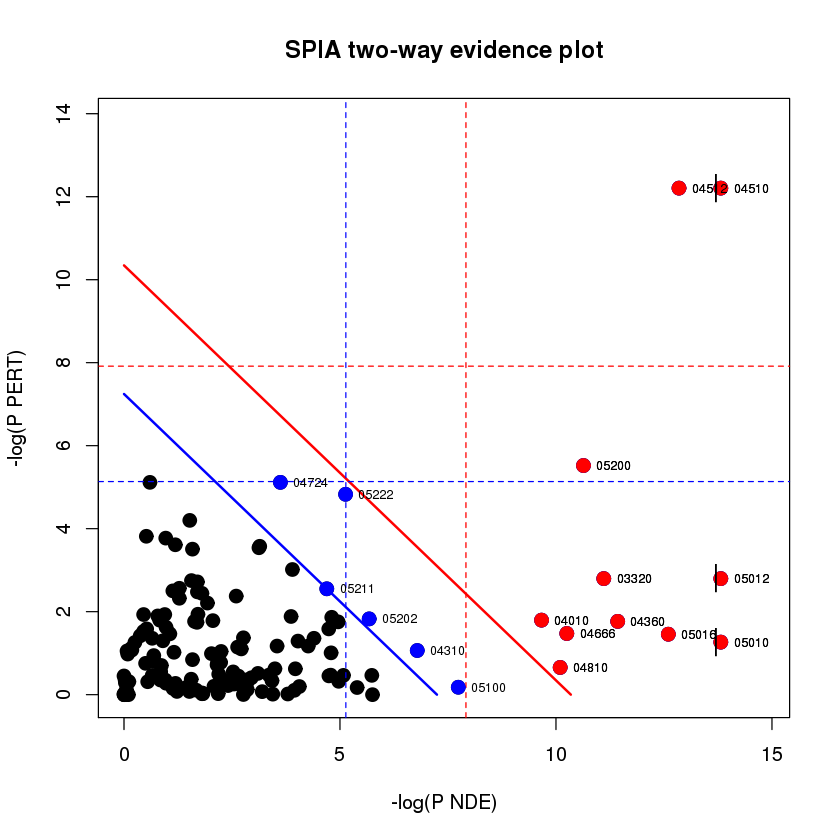

In [35]:
 plotP(res,threshold=0.05)

###### Note: SPIA provides a function to convert the latest KEGG xml files to RData format to use with the pathway analysis

In [34]:
?makeSPIAdata

makeSPIAdata {SPIA},R Documentation
kgml.path,Character vector giving the location of the folder containing two or more KEGG xml files. See for e.g. http://www.genome.jp/kegg/pathway/hsa/hsa04010.html and click the Download KGML to get such files. Users that have a license to the KEGG ftp directory can copy all the xml files corresponding to a givne organism.
organism,A three letter character designating the organism. See a full list at ftp://ftp.genome.jp/pub/kegg/xml/organisms.
out.path,"Directory where a ""organism""SPIA.RData file will be saved. If left to null, it will will try to save the file in th extdata folder of the SPIA library."


In [33]:
sessionInfo()

R version 3.2.3 (2015-12-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] SPIA_2.22.0             KEGGgraph_1.28.0        mygene_1.6.0           
 [4] GenomicFeatures_1.22.13 AnnotationDbi_1.32.3    Biobase_2.30.0         
 [7] GenomicRanges_1.22.4    GenomeInfoDb_1.6.3      IRanges_2.4.8          
[10] S4Vectors_0.8.11        BiocGenerics_0.16.1    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.3                lattice_0.20-33   

### Your homework

Using SPIA to perform a pathway analysis using the dataset from a recent paper:

Quantitative proteomic analyses of mammary organoids reveals distinct signatures after exposure to environmental chemicals
PNAS 2016 113 (10) E1343-E1351; published ahead of print February 22, 2016, [doi:10.1073/pnas.1600645113](http://www.pnas.org/content/113/10/E1343.full)


###### Input dataset:

* The dataset is provided as an excel file:

  https://www.dropbox.com/s/b85uxcwd9ez7xw2/pnas.1600645113.sd01_modified.xlsx?dl=0
  
  This file is modified from this paper's supplementary data S1. EntrezGene column was added, and 214 rows were removed due to no or non-unique mapping from uniprot to entrezgene.
  
* The values under columns **BPA**, **E2**, **PCB**, **Pht** are the log-transformed protein iTRAQ ratios, indicating the significant changes in protein abundance. The values under **P value** are already multiple-testing corrected FDRs.


##### Your assignment:

1. Read the entire dataste into R. You might need to convert the data file into csv first.

2. Pick any chemical results, one of **BPA**, **E2**, **PCB**, **Pht**, filter for genes with P values ≤0.05 and log fold changes > 0.6, that is the input gene.list for your spia analysis.

3. Perform SPIA analysis. The entire list of genes in this spreadsheat should be your background genes. Note that this dataset is for mouse, make sure you set ```organism="mmu"``` in spia.

4. For your filtered input gene.list in step 2, get their KEGG pathway mappings using map2pathway function.


##### What you need to turn in:

1. Your entire code. Indicate which chemical you picked at the beginning of the code.

2. The output from you code, including:
   * spia result table for pGFdr<=0.05
   * spia plot from plotP, using threshold=0.05
   * Your output from map2pathway



   